<a href="https://colab.research.google.com/github/NosenkoArtem/Categorical-Encoding/blob/master/hw4_NosenkoArtem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашние задание: введение в LLM 2

В этом домашнем задании мы разберем более современные архитектурные модификации LLM такие как RoPE, RMSNorm и обучим свою мини-LLM с нуля

## Скачиваем данные

In [1]:
! wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2025-03-28 17:40:19--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.04s   

2025-03-28 17:40:19 (25.5 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [2]:
! pip install jaxtyping==0.2.34 transformers==4.48.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 95.2 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.2
    Uninstalling typeguard-4.4.2:
      Successfully uninstalled typeguard-4.4.2
  Attempting uninstall: transformers
    Found existing installation: transformers 4.50.0
    Uninstalling transformers-4.50.0:
      Successfully uninstalled transformers-4.50.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [5]:
import sys
import torch

# import torch as t
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import math
from tqdm.notebook import tqdm
from typing import Tuple, List, Optional, Dict, Callable
from jaxtyping import Float, Int
from transformers import AutoTokenizer

In [6]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Подготовка данных - 15 баллов

У нас есть текст пьесы Шекспира

In [7]:
with open("input.txt") as fin:
    text = fin.read()

print(text[:200])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you


Создаем токенайзер, обратите внимание, что у токена there должен быть вначале спецсимвол, обозначающий, что это новое слово, а не часть предыдущего!

In [8]:
tokenizer = AutoTokenizer.from_pretrained("openai-community/gpt2")
print(tokenizer.tokenize("Hello there sometrashtoken"))
print(tokenizer.eos_token)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

['Hello', 'Ġthere', 'Ġsomet', 'r', 'ash', 'token']
<|endoftext|>


В токенайзере нет спецтокена под паддинг, поэтому выставим PAD_TOKEN = EOS_TOKEN

In [9]:
tokenizer.pad_token = tokenizer.eos_token
tokenizer.pad_token_id = tokenizer.eos_token_id

In [10]:
tokenizer.pad_token_id

50256

## Датасет - 5 баллов

Нам нужен Dataset - что-то, что будет держать данные.
Почитать подробнее можно в [документации](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) или на [примерах](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html).


Если кратко:
* Dataset должен реализовывать 2 метода: `__getitem__` для получения сэмплов и `__len__` для получения длины датасета
* Нужна функция collate_fn - она будет собирать несколько сэмплов из датасета в один батч
* Нужен DataLoader - объект, который будет брать объекты из датасета и с помощью collate_fn возвращать батчи
* Нужен Sampler - объект, который помогает DataLoader выбирать батчи. В нашем случае это будет просто рандом, но можно собирать сэмплы по одинаковой длине или упорядочить в зависимости от задачи.


Начнем с Dataset. В нем нужно дописать 3 функции, самая важная конструктор `__init__`:
1. Принимает корпус текста
2. Токенизирует его весь
2. Бьем текст на непересекающиеся окна размером 200-300 токенов (длину определяем с помощью random.randint)
3. Кладет токены в self.texts полученный List\[int\], то есть уже векторизованные тексты

In [11]:
from typing import List
import random
from torch.utils.data import Dataset, DataLoader


class MyDataset(Dataset):

    def __init__(self, tokenizer: AutoTokenizer, text: str):
        self.tokenizer = tokenizer
        self.texts = []
        random.seed(1)
        tokens = tokenizer.encode(text)
        chunk_size = random.randint(200, 300)
        for i in range(0, len(tokens), chunk_size):
            chunk = tokens[i:i+chunk_size]
            self.texts.append(chunk)
        # ---- Ваш код здесь ----
        # raise NotImplemented()
        # ---- Конец кода ----



    def __getitem__(self, index) -> List[int]:
        return self.texts[index]


    def __len__(self) -> int:
        return len(self.texts)


dataset = MyDataset(tokenizer, text)

sample_0 = dataset.tokenizer.decode(dataset[0])

assert sample_0.startswith(text[:100])

chunks = []
for chunk in tqdm(dataset):
  sample_i = dataset.tokenizer.decode(chunk)
  chunks.append(sample_i)

assert ''.join(chunks) == text

print(sample_0)

Token indices sequence length is longer than the specified maximum sequence length for this model (338025 > 1024). Running this sequence through the model will result in indexing errors


  0%|          | 0/1558 [00:00<?, ?it/s]

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that



## Collate FN - 5 баллов
Функция сборки, она же collate_fn. Она принимает батч сэмплов, т.е. список объектов, которые нам возвращает датасет!
Она должна принимать `List[List[int]]` батч объектов и возвращать 2 тензора:

* input_ids - `[batch, seq_len]` - батч токенов, в котором добавлены паддинги до максимальной длины в **текущем батче**.
* mask - `[batch, seq_len]` - батч масок. На позиции `[i, j]` стоит 0, если токен является паддингом, иначе 1.

В качестве значения паддинга для input_ids используйте `tokenizer.pad_token_id`

In [12]:
from torch.nn.utils.rnn import pad_sequence
from torch import tensor

In [13]:
def collate_fn(batch: List[List[int]]) -> Tuple[torch.LongTensor, torch.LongTensor]:
  batch = [torch.tensor(x) for x in batch]
  pad_batch_tensor = pad_sequence(batch, batch_first=True,
                                  padding_value=tokenizer.pad_token_id).long()
  mask = (pad_batch_tensor != tokenizer.pad_token_id).long()

  return pad_batch_tensor, mask

    # ---- Ваш код здесь ----
    # raise NotImplemented()
    # ---- Конец кода ----



batch = [
    [1, 2, 3, 4],
    [1, 2],
    [1, 2, 3, 4, 5, 6, 7],
]
input_ids_ref = torch.LongTensor([
    [1, 2, 3, 4, 50256, 50256, 50256],
    [1, 2, 50256, 50256, 50256, 50256, 50256],
    [1, 2, 3, 4, 5, 6, 7],
])


mask_ref = torch.LongTensor([
    [1, 1, 1, 1, 0, 0, 0],
    [1, 1, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 1, 1],
])

input_ids, mask = collate_fn(batch)

assert (input_ids == input_ids_ref).all()
assert (mask == mask_ref).all()
print("All good")

All good


## Соберем DataLoader - 5 баллов

Нужно заполнить пропущенные поля и убедиться, что в датасете есть замаскированные токены!

In [14]:
from torch.utils.data.sampler import RandomSampler

BATCH_SIZE = 16

# ---- Ваш код здесь ----
sampler = RandomSampler(dataset)
train_loader = DataLoader(dataset,
                          batch_size=BATCH_SIZE,
                          collate_fn=collate_fn,
                          sampler=sampler,
                          # shuffle=(sampler is None)
)

# ---- Конец кода ----


for input_ids, mask in train_loader:
    break

assert (mask.sum(dim=1) < mask.size(1)).sum() < mask.size(0)
assert input_ids.size(0) == 16
print("all good")

all good


# Transformer - 20 баллов

Немного модфицированный блок трансформера, который мы скопируем с предыдущего занятия!

In [15]:
import torch
import torch.nn as nn
from dataclasses import dataclass


@dataclass
class Config:
    d_model: int = 768 # он же hidden_dim - внутрення размерность модели
    debug: bool = True
    layer_norm_eps: float = 1e-5
    d_vocab: int = 50257 # он же vocab_size, размер словаря модели
    init_range: float = 0.02
    n_ctx: int = 1024 # число позиционных эмбеддингов
    d_head: int = 64 # размерность головы аттеншена
    d_mlp: int = 3072 # внутренняя размерность FFN-слоя
    n_heads: int = 12 # число голов аттеншена
    n_layers: int = 12 # число слоев трансформера

cfg = Config()
print(cfg)

Config(d_model=768, debug=True, layer_norm_eps=1e-05, d_vocab=50257, init_range=0.02, n_ctx=1024, d_head=64, d_mlp=3072, n_heads=12, n_layers=12)


Эти модули остаются без изменений!
Скопируйте их из предыдущего домашнего задания.

In [16]:
from torch.nn.functional import embedding

class Embed(nn.Module):
    def __init__(self, cfg: Config):
        super().__init__()
        self.cfg = cfg
        self.W_E = nn.Parameter(torch.empty((cfg.d_vocab, cfg.d_model)))
        nn.init.normal_(self.W_E, std=self.cfg.init_range)

    def forward(self, input_ids: Int[Tensor, "batch seq_len"]) -> Float[Tensor, "batch seq_len d_model"]:
        # Ваш код здесь!

        # return self.W_E[input_ids]
        # return einops.rearrange(self.W_E[input_ids], "batch seq_len d_model -> batch seq_len d_model")
        return embedding(input_ids, self.W_E)



class Unembed(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.W_U = nn.Parameter(torch.empty((cfg.d_model, cfg.d_vocab)))
        nn.init.normal_(self.W_U, std=self.cfg.init_range)
        self.b_U = nn.Parameter(torch.zeros((cfg.d_vocab), requires_grad=False))

    def forward(
        self, x: Float[Tensor, "batch seq_len d_model"]
    ) -> Float[Tensor, "batch seq_len d_vocab"]:
        # Ваш код здесь!
        return x @ self.W_U + self.b_U

class MLP(nn.Module):
    def __init__(self, cfg: Config):
        super().__init__()
        self.cfg = cfg
        self.W_in = nn.Parameter(torch.empty((cfg.d_model, cfg.d_mlp)))
        self.W_out = nn.Parameter(torch.empty((cfg.d_mlp, cfg.d_model)))
        self.b_in = nn.Parameter(torch.zeros((cfg.d_mlp)))
        self.b_out = nn.Parameter(torch.zeros((cfg.d_model)))
        nn.init.normal_(self.W_in, std=self.cfg.init_range)
        nn.init.normal_(self.W_out, std=self.cfg.init_range)

    def forward(
        self, x: Float[Tensor, "batch seq_len d_model"]
    ) -> Float[Tensor, "batch seq_len d_model"]:
        # Ваш код здесь
        x_lin = x @ self.W_in + self.b_in
        z = F.gelu(x_lin, approximate="tanh")
        out = z @ self.W_out + self.b_out
        return out



## RMSNorm - 5 баллов

Здесь нужно написать RMSNorm. В качестве формулы стоит ориентироваться на формулу 4 из [статьи RMSNorm](https://arxiv.org/pdf/1910.07467)


$$\bar{x}_i = \frac{x_i}{\text{RMS}(\mathbf{x})} w_i, \quad \text{where} \quad \text{RMS}(\mathbf{x}) = \sqrt{\frac{1}{n} \sum_{i=1}^{n} x_i^2}$$



In [18]:
class RMSNorm(nn.Module):
    def __init__(self, cfg: Config):
        super().__init__()
        self.cfg = cfg
        self.w = nn.Parameter(torch.ones(cfg.d_model)) # gamma

    def forward(self, x: Float[Tensor, "batch seq_len d_model"]) -> Float[Tensor, "batch seq_len d_model"]:
        # ---- Ваш код здесь ----
        # raise NotImplemented()
        return x / ((x ** 2).mean(-1, keepdim=True)) ** 0.5
        # ---- Конец кода ----



cfg_rmsnorm = Config(d_model=5)
x = torch.Tensor([[[0.1, 0.2, 0.3, 0.4, 0.5]]]).to(device)
layer = RMSNorm(cfg_rmsnorm).to(device)
y = torch.Tensor([[[0.3015, 0.6030, 0.9045, 1.2060, 1.5076]]]).to(device)
assert torch.allclose(y, layer(x), atol=1e-4, rtol=1e-3)
print("OK")

OK


## Rotary Embeddings - 5 баллов

Нужно написать роторные эмбеддинги из [статьи](https://arxiv.org/pdf/2104.09864). В качестве формулы нужно взять пункт 3.4.2!


In [19]:
class RotaryPositionalEmbeddings(nn.Module):

    def __init__(self, cfg: Config, theta: int = 10_000):
        super().__init__()
        self.cfg = cfg
        self.max_seq_len = cfg.n_ctx
        self.theta = theta
        self.d = cfg.d_head

        # ---- Ваш код здесь ----
        # Углы theta_i. Смотрите секуцию 2.2 статьи для формулы!
        freqs = 1 / ((self.theta) ** (torch.arange(0, self.d, 2).float() / self.d))
        position_id = torch.arange(0, self.max_seq_len).float()

        # нужно получить матрицу m theta_i размера [max_seq_len, self.d] вида m theta_i
        # где m берется из position_id, а theta из freqs

        idx_theta = torch.outer(position_id, freqs)   #(max_seq_len, self.d)

        # max_seq_len, d_head
        cos = idx_theta.cos()
        sin = idx_theta.sin()

        # нужно продублировать размерности для формулы 34. theta_i встерчается два раза подряд в синусах и косинуса
        # тут нам поможет torch.repeat_interleave
        cos = cos.repeat_interleave(2, dim=1)          #(max_seq_len, 2*self.d)
        sin =  sin.repeat_interleave(2, dim=1)         #(max_seq_len, 2*self.d)
        # ---- Конец кода ----



        # 1, max_seq_len, 1, d_head
        self.register_buffer("sin", sin.view(1, self.max_seq_len, 1, self.d))
        self.register_buffer("cos", cos.view(1, self.max_seq_len, 1, self.d))

    @staticmethod
    def rotate_neg_vector(x: Float[torch.Tensor, "batch seq_len num_heads d_head"]):
        # На входе x = [x1, x2, x3, x4, ... x_{n-1}, x_n]
        # На выходе x' = [-x2, x1, -x4, x3, ..., -x_n, x_{n-1}]
        x_new = torch.empty_like(x)

        x_new[:, :, :, ::2] = - x[:, :, :, 1::2] # отрицательные значения
        x_new[:, :, :, 1::2] = x[:, :, :, ::2]   # положительные значения
        # ---- Ваш код здесь ----
        # raise NotImplemented()
        # ---- Конец кода ----

        return x_new

    def forward(self, x: Float[torch.Tensor, "batch seq_len num_heads d_head"]):
        seq_len = x.size(1)
        x_rot = self.rotate_neg_vector(x)

        # ---- Ваш код здесь ----
        x_rope = x * self.cos[:, :seq_len, :, :] + x_rot * self.sin[:, :seq_len, :, :] # формула 34
        # ---- Конец кода ----

        return x_rope




batch_size = 1
seq_len = 3
num_heads = 1
d_head = 16

torch.manual_seed(1)
x = torch.rand(batch_size, seq_len, num_heads, d_head)

rope_config = Config(
    n_heads=2,
    d_head=16,
)

rope_layer = RotaryPositionalEmbeddings(rope_config)
y = rope_layer(x)


from math import sin, cos


thetas = [10_000 ** (-2 * (i - 1) / rope_config.d_head) for i in range(1, rope_config.d_head // 2 + 1)]
all_good = True
for batch_idx in range(batch_size):
    for m in range(seq_len):
        if not all_good:
            break
        for head_idx in range(num_heads):
            if not all_good:
                break
            for d_idx in range(d_head):
                # 0, 2, 4
                if d_idx % 2 == 0:
                    val = x[batch_idx, m, head_idx, d_idx] * cos(m * thetas[d_idx // 2]) - x[batch_idx, m, head_idx, d_idx + 1] * sin(m * thetas[d_idx // 2])
                else:
                    val = x[batch_idx, m, head_idx, d_idx] * cos(m * thetas[d_idx // 2]) + x[batch_idx, m, head_idx, d_idx - 1] * sin(m * thetas[d_idx // 2])
                if abs(y[batch_idx, m, head_idx, d_idx] - val) > 1e-3:
                    print(f"Ошибка на позиции {m} и размерности {d_idx} в голове {head_idx}")
                    print(f"Полученное значение {y[batch_idx, m, head_idx, d_idx]}, референс {val}")
                    all_good = False
                    break


if all_good:
    print("Тесты прошли успешно!")


Тесты прошли успешно!


##  Attention masking - 3 балла

Копируем имлементацию из предыдущего домашнего задания, но теперь нужно учесть и маски с паддингами.
Для этого в `forward` и `apply_causal_mask` подана mask.

В оригинальном задании 3 мы считали, что паддингов нет, поэтому делали маску нижней треугольной, чтобы токен i смотрел на токен j только тогда, когда `i >= j`, т.е. токен i мог смотреть все токены до него.

Теперь же нужно сверх этого добавить еще и паддинг, т.е:

1. Нам дается маска `[batch_size, seq_len]` из `collate_fn`. Напомню, что на позиции `[batch_idx, m]` стоит 1, если токен настоящий или 0, если это паддинг
2. Мы должны модифицировать нашу нижнюю треугольную маску таким образом, чтобы не только не смотреть в будущее, но и не смотреть на паддинг.


## Attention Rotary Embedding - 2 балла
Также нужно вставить в attention слой роторные эмбеддинги:
1. Нужно добавить их в init метод модели, в качестве theta можно оставить 10000
2. Нужно применять их к матрицам Q, K перед матричным умножением $Q K^T$ в функции _get_qkv

In [20]:
class Attention(nn.Module):
    IGNORE: Float[Tensor, ""]

    def __init__(self, cfg: Config):
        super().__init__()
        self.cfg = cfg

        self.W_Q = nn.Parameter(torch.empty((cfg.n_heads, cfg.d_model, cfg.d_head)))
        self.b_Q = nn.Parameter(torch.zeros((cfg.n_heads, cfg.d_head)))

        self.W_K = nn.Parameter(torch.empty((cfg.n_heads, cfg.d_model, cfg.d_head)))
        self.b_K = nn.Parameter(torch.zeros((cfg.n_heads, cfg.d_head)))

        self.W_V = nn.Parameter(torch.empty((cfg.n_heads, cfg.d_model, cfg.d_head)))
        self.b_V = nn.Parameter(torch.zeros((cfg.n_heads, cfg.d_head)))

        self.W_O = nn.Parameter(torch.empty((cfg.n_heads, cfg.d_head, cfg.d_model)))
        self.b_O = nn.Parameter(torch.zeros((cfg.d_model)))



        # ---- Ваш код здесь ----
        self.rope = RotaryPositionalEmbeddings(cfg=cfg, theta=10_000)
        # ---- Конец кода ----


        nn.init.normal_(self.W_Q, std=self.cfg.init_range)
        nn.init.normal_(self.W_K, std=self.cfg.init_range)
        nn.init.normal_(self.W_V, std=self.cfg.init_range)
        nn.init.normal_(self.W_O, std=self.cfg.init_range)
        self.register_buffer("IGNORE", torch.tensor(float("-inf"), dtype=torch.float32, device=device))

    def _get_qkv(
        self, x: Float[Tensor, "batch seq_len d_model"]
    ) -> Tuple[Float[Tensor, "batch seq_len num_heads d_head"]]:
        """1. Трансформируем матрицы проекций в формат [d_model, d_model] и получаем проекции  Q, K, V"""
        # Берем размерности
        batch_size, seq_len, d_model = x.shape
        num_heads = self.cfg.n_heads
        d_head = self.cfg.d_head

        W_Q = self.W_Q.permute(1, 0, 2).reshape(self.cfg.d_model, self.cfg.d_model)
        W_K = self.W_K.permute(1, 0, 2).reshape(self.cfg.d_model, self.cfg.d_model)
        W_V = self.W_V.permute(1, 0, 2).reshape(self.cfg.d_model, self.cfg.d_model)

        b_Q = self.b_Q.view(-1)
        b_K = self.b_K.view(-1)
        b_V = self.b_V.view(-1)


        # ---- Ваш код здесь ----
        Q = x @ W_Q + b_Q
        K = x @ W_K + b_K
        V = x @ W_V + b_V

        Q = Q.reshape(batch_size, seq_len, num_heads, d_head)
        K = K.reshape(batch_size, seq_len, num_heads, d_head)
        V = V.reshape(batch_size, seq_len, num_heads, d_head)

        Q = self.rope(Q) # применяем rope
        K = self.rope(K)

        # не забудьте применить self.rotary после проекций!
        # ---- Конец кода ----


        return Q, K, V

    def _get_attention_dotprod(
        self,
        Q: Float[Tensor, "batch seq_len num_heads d_head"],
        K: Float[Tensor, "batch seq_len num_heads d_head"]
    ) -> Float[Tensor, "batch num_heads seq_len seq_len"]:
        """Q x K^T"""
        # Ваш код здесь
        d_head = self.cfg.d_head
        num_heads = self.cfg.n_heads
        d_head = self.cfg.d_head
        seq_len = Q.shape[1]

        K = K.permute(0, 2, 3, 1) # "batch num_heads d_head  seq_len"
        Q = Q.permute(0, 2, 1, 3) # "batch num_heads seq_len d_head"

        dotprod = Q @ K
        return dotprod

    def _get_attention_scores(
        self,
        attention_scores: Float[Tensor, "batch num_heads seq_len seq_len"],
        mask: Int[Tensor, "batch seq_len"]
    ) -> Float[Tensor, "batch num_heads seq_len seq_len"]:
        """Нормализация, маскирование и softmax"""
        # ---- Ваш код здесь ----
        d_head = self.cfg.d_head
        masked_att_scores = self.apply_causal_mask(attention_scores, mask) # batch n_heads seq_len seq_len
        attn_probs = torch.softmax(masked_att_scores / (d_head)**0.5, dim=-1)
        return attn_probs
        # ---- Конец кода ----

    def _get_final_projection(
        self,
        V: Float[Tensor, "batch seq_len num_heads d_head"],
        attn_probs: Float[Tensor, "batch num_heads seq_len seq_len"]
    ) -> Float[Tensor, "batch seq_len d_model"]:
        """Финальная проекция
        permute [ batch, num_heads, seq_len, d_head]"""
        batch_size, seq_len = V.shape[0], V.shape[1]
        d_model = self.cfg.d_model
        num_heads = self.cfg.n_heads
        d_head = self.cfg.d_head

        premute_V = V.permute(0, 2, 1, 3) # --> (batch num_heads seq_len d_head)

        res = attn_probs @ premute_V # (batch num_heads seq_len seq_len) * (batch num_heads seq_len d_head) -->  (batch num_heads seq_len d_head)
        res = res.permute(0, 2, 1, 3).reshape(batch_size, seq_len, num_heads * d_head) # (batch seq_len d_model)
        # Ваш код здесь
        return res @ self.W_O.reshape(d_model, d_model)  + self.b_O # (batch seq_len d_model) * (n_heads, d_head, d_model) --> (batch seq_len d_model)

    def forward(
        self, x: Float[Tensor, "batch seq_len d_model"],  mask: Int[Tensor, "batch seq_len"]
    ) -> Float[Tensor, "batch seq_len d_model"]:
        # 1. получаем проекции  Q, K, V
        Q, K, V = self._get_qkv(x)
        # 2. Q x K^T
        attention_scores = self._get_attention_dotprod(Q, K)

        # 3. Нормализация, маскирование и softmax
        attn_probs = self._get_attention_scores(attention_scores, mask)

        # 6. Финальная проекция
        # permute [ batch, num_heads, seq_len, d_head]
        res = self._get_final_projection(V, attn_probs)
        return res

    def apply_causal_mask(
        self, attn_scores: Float[Tensor, "batch n_heads seq_len seq_len"], mask: Int[Tensor, "batch seq_len"]
    ) -> Float[Tensor, "batch n_heads seq_len seq_len"]:
        '''
        Applies a causal mask to attention scores, and returns masked scores.
        Используем треугольную маску, чтобы не смотреть в будущее!
        В качестве масикировочного значения перед софтмаксом можно использовать self.IGNORE (-inf)

        В дополнение к предыдущему заданию используйте аргумент mask, чтобы не смотреть не только на будущие токены,
        но и на паддинги.
        Сами паддинги могут смотреть на любые токены.
        '''
        seq_len = mask.size(1)
        # ---- Ваш код здесь ----
        # создаем верхнетреугольную матрицу с inf
        mask_inf = torch.full_like(attn_scores, fill_value=self.IGNORE)
        tri_mask_inf = torch.triu(mask_inf, diagonal=1)

        # создаем нижнетреульную матрицу c score
        tri_attn_scores = torch.tril(attn_scores)

        # формируем маску для паддингов
        mask = mask.unsqueeze(1).unsqueeze(-2).float()
        mask_ = (mask == 0)
        mask_padding = mask.masked_fill(mask_, value=-torch.inf)

        masked_att_scores = tri_mask_inf + tri_attn_scores + mask_padding

        return masked_att_scores
        # ---- Конец кода ----


mask_padding = torch.LongTensor([
    [1, 1, 1, 1, 0, 0, 0],
    [1, 1, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 1, 1],
]).to(device)

lengths = mask_padding.sum(dim=1).tolist()


batch_size = 3
seq_len = 7
d_head = 8
n_heads = 4
torch.manual_seed(1)
x = torch.rand(batch_size, n_heads, seq_len, seq_len).to(device)

attn = Attention(cfg).to(device)
softmax_res = torch.softmax(attn.apply_causal_mask(x, mask_padding), dim=-1)

for batch_idx in range(batch_size):
    for head_idx in range(n_heads):
        sm = softmax_res[batch_idx, head_idx]
        l = lengths[batch_idx]
        for i in range(seq_len):
            for j in range(seq_len):
                # i < j - Causal mask, проверяем, что не смотрим в будущее!
                # j >= l - проверяем, что не смотрим на паддинги!
                if i < j or j >= l:
                    assert sm[i, j] == 0, (batch_idx, head_idx, i, j, sm[i, j])

_ = attn(torch.rand(batch_size, seq_len, 768).to(device), mask_padding.to(device))
print("All good")

All good


## Собираем Transformer - 5

1. В TransformerBlock и DemoTransformer немного модифицируем код из предыдущего задания, чтобы передавать mask в слои аттеншена.
2. Не используем позиционные эмбеддинги, т.к. кодирование позиционной информации уже заложено в роторные эмбеддинги, которые являются частью attention слоя


In [21]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg: Config):
        super().__init__()
        self.cfg = cfg
        self.ln1 = RMSNorm(cfg)
        self.attn = Attention(cfg)
        self.ln2 = RMSNorm(cfg)
        self.mlp = MLP(cfg)

    def forward(
        self, x: Float[Tensor, "batch seq_len d_model"], mask: Float[Tensor, "batch seq_len"]
    ) -> Float[Tensor, "batch seq_len d_model"]:
        # ---- Ваш код здесь ----
        # raise NotImplemented()
        # ---- Конец кода ----
        x = x + self.attn(self.ln1(x), mask)
        x = x + self.mlp(self.ln2(x))
        return x


class DemoTransformer(nn.Module):
    def __init__(self, cfg: Config):
        super().__init__()
        self.cfg = cfg
        self.embed = Embed(cfg)
        self.blocks = nn.ModuleList([TransformerBlock(cfg) for _ in range(cfg.n_layers)])
        self.ln_final = RMSNorm(cfg)
        self.unembed = Unembed(cfg)

    def forward(self, input_ids: Int[Tensor, "batch seq_len"], mask: Int[Tensor, "batch seq_len"]) -> Float[Tensor, "batch seq_len d_vocab"]:
        # ---- Ваш код здесь ----
        # raise NotImplemented()
        # ---- Конец кода ----
        x = self.embed(input_ids)
        for block in self.blocks:
            x = block(x, mask)
        x = self.unembed(self.ln_final(x))
        return x

In [22]:
train_config = Config(
    d_model=128,
    n_ctx=512,
    n_heads=8,
    d_head=16,
    d_mlp=512,
    n_layers=12
)
model = DemoTransformer(train_config).to(device)

for input_ids, mask in train_loader:
    break

p = model(input_ids.to(device), mask.to(device))


assert list(p.shape) == [input_ids.size(0), input_ids.size(1), train_config.d_vocab]
p.sum().backward()

del model
del p
print("all good")

all good


# Обучение - 15 баллов

## calculate_loss - 5

Здесь нужно написать обычный training loop. Вначале напишем функцию для подсчета функции потерь `calculate_loss`. Функция принимает выходы модели logits размерности \[batch_size, seq_len, vocab_size\], input_ids размерности \[batch_size, seq_len\] и attention_mask размерности \[batch_size, seq_len\].

Так как мы хотим учиться на задаче языкового моделирования, в logits на позиции \[i, j\] находится распределение токенов по словарю для токена на позиции \[i, j + 1\] (мы предсказываем следующий токен). Каждое такое предсказание следующего токена мы будем рассматривать как задачу классификации и учить с помощью кроссэнтропийной функции потерь.

Алгоритм:
1. Обрезаем logits по размерности seq_len справа на 1: последний токен на позиции N у нас предсказывает токен на позиции N + 1, однако (N + 1)-го токена у нас нет, поэтому использовать эти предсказания для обучения мы не сможем.
2. Заводим переменную labels - для этого обрезаем input_ids слева на 1. Это будет наш массив меток. Мы обрезаем его слева на 1 по размерности seq_len, т.е. по сути сдвигагем этот массив таким образом, что на j-й позиции теперь стоит (j + 1)-й токен. Это очень важно для подсчета функции потерь, т.к. мы предсказываем следующий токен
3. Аналогично labels обрезаем attention_mask и переводим маску в `.bool()`
4. На позициях, где attention_mask == 0 (паддинги) проставляем в labels значение -100. Это дефолтное значение [ignore_index](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) из кроссэнтропийной функции потерь, означающее, что для этой метки не будет считаться функция потерь. Таким образом мы не будем учиться предсказывать паддинги
5. Объеднияем в logits и labels размерности batch и seqlen с помощью view и подаем это в кроссэнтропийную функцию потерь, считаем loss


In [24]:
from math import log


criterion = nn.CrossEntropyLoss()
pad_id = tokenizer.pad_token_id

def calculate_loss(logits, input_ids, attention_mask):
    labels = input_ids.detach().clone()
    # ---- Ваш код здесь ----
    # raise NotImplemented()
    # ---- Конец кода ----
    labels = labels[:, 1:]
    attention_mask = attention_mask[:, 1:].bool()
    labels[~attention_mask] = -100

    logits = logits[:, :-1]

    loss = criterion(logits.reshape(-1, logits.size(-1)), labels.reshape(-1))
    return loss

batch_size = 2
seq_len = 4
num_classes = 7

input_ids = torch.LongTensor(
    [
        [0, 1,  pad_id, pad_id],
        [0, 1, 2, 3]
    ]
)

attention_mask = torch.LongTensor(
    [
        [1, 1, 0, 0],
        [1, 1, 1, 1]
    ]
)


# batch_size, seq_len, num_classes
logits = torch.Tensor(
    [[[0.7576, 0.2793, 0.4031, 0.7347, 0.0293, 0.7999, 0.3971],
         [0.7544, 0.5695, 0.4388, 0.6387, 0.5247, 0.6826, 0.3051],
         [0.4635, 0.4550, 0.5725, 0.4980, 0.9371, 0.6556, 0.3138],
         [0.1980, 0.4162, 0.2843, 0.3398, 0.5239, 0.7981, 0.7718]],

        [[0.0112, 0.8100, 0.6397, 0.9743, 0.8300, 0.0444, 0.0246],
         [0.2588, 0.9391, 0.4167, 0.7140, 0.2676, 0.9906, 0.2885],
         [0.8750, 0.5059, 0.2366, 0.7570, 0.2346, 0.6471, 0.3556],
         [0.4452, 0.0193, 0.2616, 0.7713, 0.3785, 0.9980, 0.9008]]]
)
logits.requires_grad=True

loss = calculate_loss(logits, input_ids, attention_mask)

assert abs(loss.item() - 1.934269905) < 1e-3
print(loss.item())

1.934269905090332


## Training loop - 5


Давайте теперь напишем training loop:
1. Перемещаем input_ids и mask на правильный device
2. Зануляем градиенты модели
3. Считаем выходы модели (logits)
4. Считаем функцию потерь с помощью функции calculate_loss
5. Делаем backward и обновляем веса оптимизатором

Учить модель лучше 10+ эпох.

Также предлагается добавлять значения функции потерь в массив losses, чтобы изобразить её изменения в следующей клетке на графике

In [28]:
import torch.optim as optim

model = DemoTransformer(cfg).to(device)

model = model.train()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

losses = []
for epoch in range(15):
    for input_ids, mask in tqdm(train_loader):
        # 1. перемещаем входы на device
        input_ids = input_ids.to(device)
        mask = mask.to(device)
        # ---- Ваш код здесь ----
        # 2. Обнуляем градиенты
        optimizer.zero_grad()
        # 3. Считаем выходы модели
        logits = model(input_ids, mask)
        # 4. считаем функцию потерь
        loss = calculate_loss(logits, input_ids, mask)
        # 5. Делаем backward и шаг оптимизации
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        # ---- Конец кода ----


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

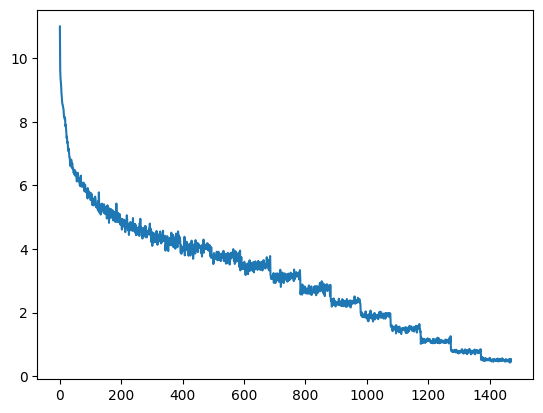

In [29]:
import matplotlib.pyplot as plt
plt.plot(losses)

## Генерация - 5 баллов
Давайте теперь попробуем посмотреть, что у нас обучилось! Для этого проверим себя на жадной генерации.

Для этого:
1. Подаем входы в модель
2. Берем последний элемент в logits по размерности seq_len и argmax по нему. Это сгенерированный токен, полученный жадным сэмплингом.
3. Конкатенируем его ко входам, конкатенируем \[\[1\]\] в маску
4. Генерируем так 30 токенов

In [30]:
input_text = text[:13]
inputs = tokenizer(input_text, return_tensors="pt")

input_ids = inputs["input_ids"].to(device)
mask = inputs["attention_mask"].to(device)

orig_size = input_ids.size(1)

num_tokens_to_generate = 100

with torch.no_grad():
    for i in tqdm(range(num_tokens_to_generate)):

        # ---- Ваш код здесь ----
        logits = model(input_ids, mask)
        next_token = torch.argmax(logits, dim=-1)[:, -1].item()

        input_ids = torch.cat((input_ids, torch.tensor([[next_token]]).to(device)), dim=1)
        mask = torch.cat((mask, torch.tensor([[1]]).to(device)), dim=1)
        # ---- Конец кода ----

print("Input text:\n", input_text)
print()
print("Generated text:\n", tokenizer.decode(input_ids[0]))

  0%|          | 0/100 [00:00<?, ?it/s]

Input text:
 First Citizen

Generated text:
 First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
The gods give-morrow is the mutinous; so is I
your common people: the people know you know; not
your own but we are too late.

Citizens:
Let us know't.

All:
We are too much:


Если все прошло успешно, то мы увидим какой-то небольшой, возможно,  повторяющийся текст. Смысла в нем скорее всего будет немного, но издалека он будет выглядеть вполне реалистично.

Осталось отмашстабировать модель, накинуть данных и получится настоящий pretrain!